# **Home Credit Default Risk**  
This project attempts to model and predict the default risk of consumer loan applicants by analyzing and extracting data from several sources including bureau data as well as previous home credit applications and installments. I divided the work into the following steps / sections:

## 1. Exploratory Data Analysis 
#### 1a. Baseline Models
\- Run logistic regression / random forest baseline models to gauge expectations and get an initial impression on main application file and the target variable  
#### 1b. Clean Data  
\- Investigate and impute null values as well as anomalies across main application file and supplemental files
#### ***1c. Feature Exploration***
\- ***Explore features by analyzing correlations and relationship with target variable (default / no default)***  
## 2. Feature Engineering
#### 2a. Supplemental Data 
\- Engineer features by grouping and flattening supplemental datasets
#### 2b. Application Data
\- Merge supplemental data with main application dataframe. Create additional features through a combination of manual calculations with domain knowledge as well as polynomial features 
## 3. Gradient Boosting Classifier
#### 3a. Train LightGBM  
\- Train LightGBM model using data and previously engineered features  
#### 3b. Model Results / Analysis  
\- Compare models and assess feature importances
  

<hr>

# __1c. Feature Exploration__

### __Sections__
1c1. Explore feature/target relationships - df_application  
1c2. Feature correlations - df_application  
1c3. EDA Summary

<hr>

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from rq_config import project_3_path

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)

In [2]:
pkl_dir = os.path.join(project_3_path,'data/','pkl/')

In [3]:
df_application = pd.read_pickle(pkl_dir + 'application_train.pkl')

### __1c1. Explore feature relationships - df_application__

In [4]:
# Convenience function to briefly analyze feature / target relationships
def crosstab(df,feature1,feature2):
    return pd.crosstab(df[feature1],df[feature2],dropna = False)

#### Dataset is imbalanced:

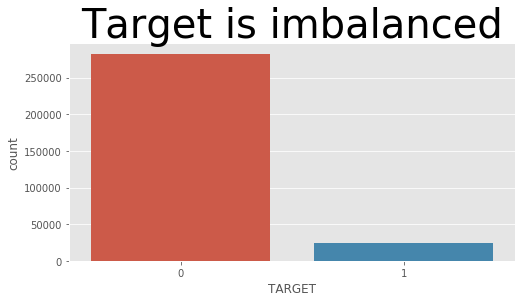

In [5]:
plt.figure(figsize = (8,4))
plt.style.use('ggplot')
plt.title('Target is imbalanced',size = 40)

sns.countplot(df_application['TARGET']);

#### Most defaults occur from cash loans:

In [6]:
crosstab(df_application,'TARGET','NAME_CONTRACT_TYPE')

NAME_CONTRACT_TYPE,Cash loans,Revolving loans
TARGET,,
0,255011,27675
1,23221,1604


#### More women take loans than men. They are also more likely to repay their loans:

In [7]:
crosstab(df_application,'TARGET','CODE_GENDER')

CODE_GENDER,F,M,XNA
TARGET,,,
0,188278,94404,4
1,14170,10655,0


#### There is no distinct target relationship for family status/children count:

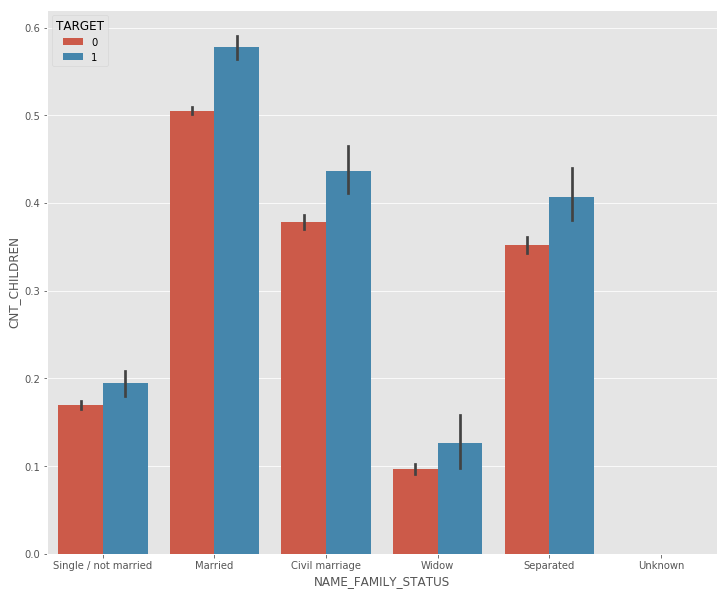

In [8]:
plt.subplots(figsize = (12,10))

sns.barplot(x='NAME_FAMILY_STATUS',y='CNT_CHILDREN',data = df_application,hue = 'TARGET');

#### More granularity behind income type. Most individuals fall within "Commercial associate, state servant, pensioner, and "working" categories:

In [9]:
crosstab(df_application,'NAME_INCOME_TYPE','OCCUPATION_TYPE')

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_INCOME_TYPE,,,,,,,,,,,,,,,,,,
Businessman,0,0,0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0
Commercial associate,3970,892,1305,6528,4916,220,3495,204,12763,370,8916,1036,989,324,11104,343,1559,386
Maternity leave,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Pensioner,0,2,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
State servant,729,261,453,6956,815,64,1033,55,1868,25,2142,2585,38,9,186,264,380,53
Student,1,0,0,3,1,0,0,0,5,2,0,0,0,0,0,0,0,1
Working,5112,3498,4188,14080,12871,279,6852,267,40548,1696,10306,4915,1625,418,20811,698,4782,908


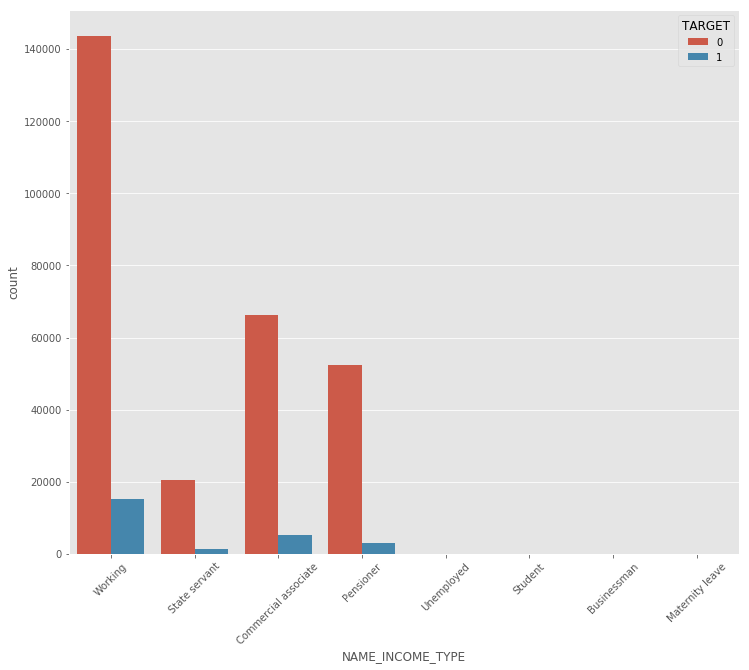

In [10]:
plt.subplots(figsize = (12,10))
plt.xticks(rotation = 45)
sns.countplot(df_application['NAME_INCOME_TYPE'],hue = df_application['TARGET']);

#### Individuals in "working" category are more likely to default on their loan payments:

In [11]:
df_income_types_total = df_application.groupby(['NAME_INCOME_TYPE']).size().reset_index()

In [12]:
df_income_types = df_application.groupby(['TARGET','NAME_INCOME_TYPE']).size().reset_index()

In [13]:
df_income_types = pd.merge(df_income_types.query("TARGET == 1"),df_income_types_total,on = 'NAME_INCOME_TYPE')

In [14]:
df_income_types

,TARGET,NAME_INCOME_TYPE,0_x,0_y
0,1,Commercial associate,5360,71617
1,1,Maternity leave,2,5
2,1,Pensioner,2982,55362
3,1,State servant,1249,21703
4,1,Unemployed,8,22
5,1,Working,15224,158774


In [15]:
df_income_types = df_income_types.rename(columns = {'0_x':'DEFAULT',
                                                   '0_y':'TOTAL'})

In [16]:
df_income_types['TARGET_PCT'] = (df_income_types['DEFAULT'] / df_income_types['TOTAL'])*100

In [17]:
df_income_types.sort_values(by = 'TARGET_PCT',ascending = False)

,TARGET,NAME_INCOME_TYPE,DEFAULT,TOTAL,TARGET_PCT
1,1,Maternity leave,2,5,40.000000
4,1,Unemployed,8,22,36.363636
5,1,Working,15224,158774,9.588472
0,1,Commercial associate,5360,71617,7.484257
3,1,State servant,1249,21703,5.754965
2,1,Pensioner,2982,55362,5.386366


#### Most defaults and loans are related to house / apartments:

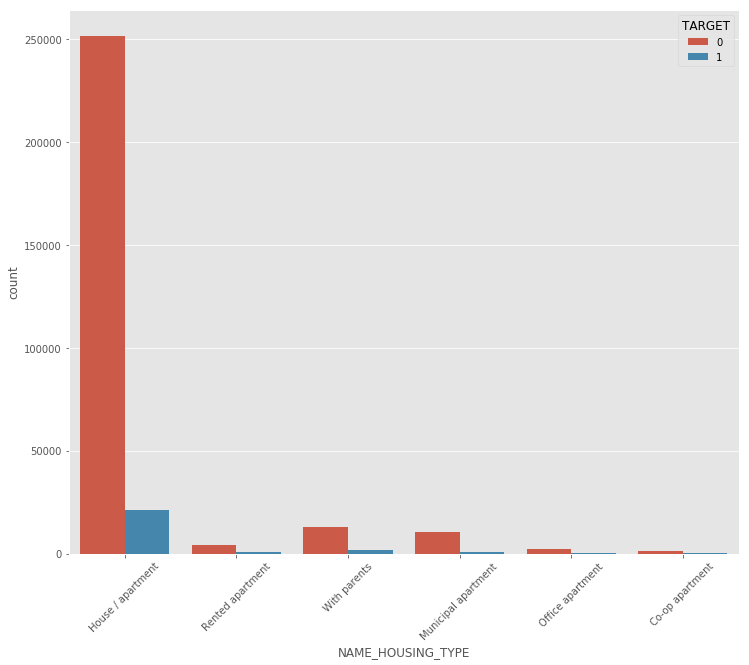

In [18]:
plt.subplots(figsize = (12,10))
plt.xticks(rotation = 45)

sns.countplot(df_application['NAME_HOUSING_TYPE'],hue = df_application['TARGET']);

#### Most loans are taken by individuals with a secondary education:

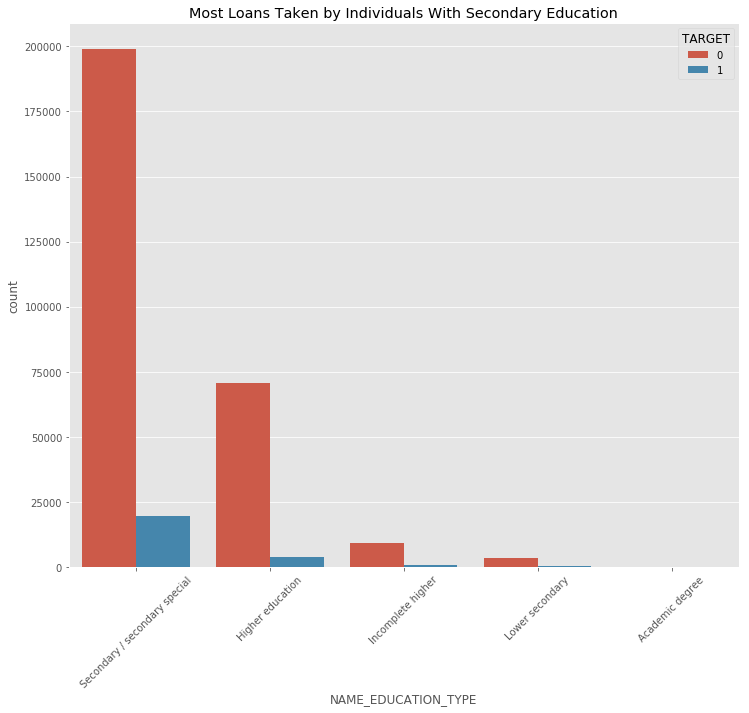

In [19]:
plt.subplots(figsize = (12,10))
plt.xticks(rotation = 45)
plt.title('Most Loans Taken by Individuals With Secondary Education')
sns.countplot(df_application['NAME_EDUCATION_TYPE'],hue = df_application['TARGET']);

In [20]:
# Convert all time features and days values to positive values

df_application['DAYS_BIRTH'] = df_application['DAYS_BIRTH'].apply(lambda x: -x)
df_application['DAYS_EMPLOYED'] = df_application['DAYS_EMPLOYED'].apply(lambda x: -x)
df_application['DAYS_REGISTRATION'] = df_application['DAYS_REGISTRATION'].apply(lambda x: -x)
df_application['DAYS_ID_PUBLISH'] = df_application['DAYS_ID_PUBLISH'].apply(lambda x: -x)

In [21]:
df_application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY_ANOMALY,DAYS_EMPLOYED_ANOMALY,OWN_CAR_AGE_ANOMALY,CNT_FAM_MEMBERS_ANOMALY,OBS_30_CNT_SOCIAL_CIRCLE_ANOMALY,OBS_60_CNT_SOCIAL_CIRCLE_ANOMALY,AMT_REQ_CREDIT_BUREAU_QRT_ANOMALY
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,637.0,3648.0,2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,1188.0,1186.0,291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,19046,225.0,4260.0,2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,19005,3039.0,9833.0,2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False
4,100007,0,Cash loans,M,N,Y,0,121500.0,513

In [22]:
days_features = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']

days_data = df_application[['TARGET','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']].copy()

In [23]:
for feature in days_features:
    days_data[feature + '_YEARS'] = days_data[feature] / 365

In [24]:
days_data.describe()

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_BIRTH_YEARS,DAYS_EMPLOYED_YEARS,DAYS_REGISTRATION_YEARS,DAYS_ID_PUBLISH_YEARS
count,307511.000000,307511.000000,252137.000000,307511.000000,307511.000000,307511.000000,252137.000000,307511.000000,307511.000000
mean,0.080729,16036.995067,2384.169325,4986.120328,2994.202373,43.936973,6.531971,13.660604,8.203294
std,0.272419,4363.988632,2338.360162,3522.886321,1509.450419,11.956133,6.406466,9.651743,4.135481
min,0.000000,7489.000000,-0.000000,-0.000000,0.000000,20.517808,-0.000000,-0.000000,0.000000
25%,0.000000,12413.000000,767.000000,2010.000000,1720.000000,34.008219,2.101370,5.506849,4.712329
50%,0.000000,15750.000000,1648.000000,4504.000000,3254.000000,43.150685,4.515068,12.339726,8.915068
75%,0.000000,19682.000000,3175.000000,7479.500000,4299.000000,53.923288,8.698630,20.491781,11.778082
max,1.000000,25229.000000,17912.000000,24672.000000,7197.000000,69.120548,49.073973,67.594521,19.717808


In [25]:
days_data['DAYS_BIRTH_YEARS_BINNED'] = pd.cut(days_data['DAYS_BIRTH_YEARS'],bins = np.linspace(20,70,num = 11))
days_data['DAYS_EMPLOYED_YEARS_BINNED'] = pd.cut(days_data['DAYS_EMPLOYED_YEARS'],bins = np.linspace(0,50,num = 11));
days_data['DAYS_REGISTRATION_YEARS_BINNED'] = pd.cut(days_data['DAYS_REGISTRATION_YEARS'],bins = np.linspace(0,70,num = 11))
days_data['DAYS_ID_PUBLISH_YEARS_BINNED'] = pd.cut(days_data['DAYS_ID_PUBLISH_YEARS'],bins = np.linspace(0,20,num = 11))

In [26]:
def plot_days_bins(group):
    df_group = days_data.groupby(group).mean()
    plt.subplots(figsize = (12,10))
    sns.barplot(x = df_group.index.astype(str),y = df_group['TARGET'],color = 'g')
    plt.ylabel('Defaulted on Loan (%)')
    plt.xticks(rotation = 45);

#### Younger clients are less likely to repay their loans:

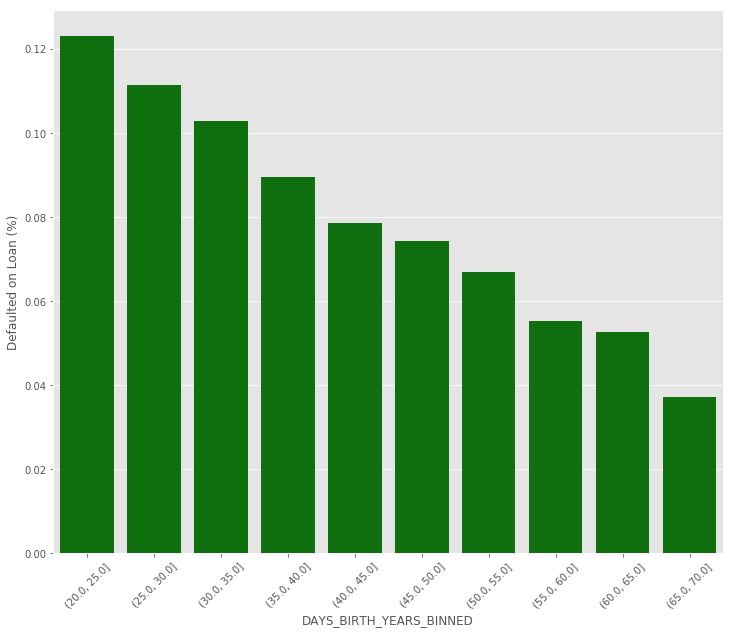

In [27]:
plot_days_bins('DAYS_BIRTH_YEARS_BINNED')

#### Applicants who just started their jobs are more likely to default on their loan payments:

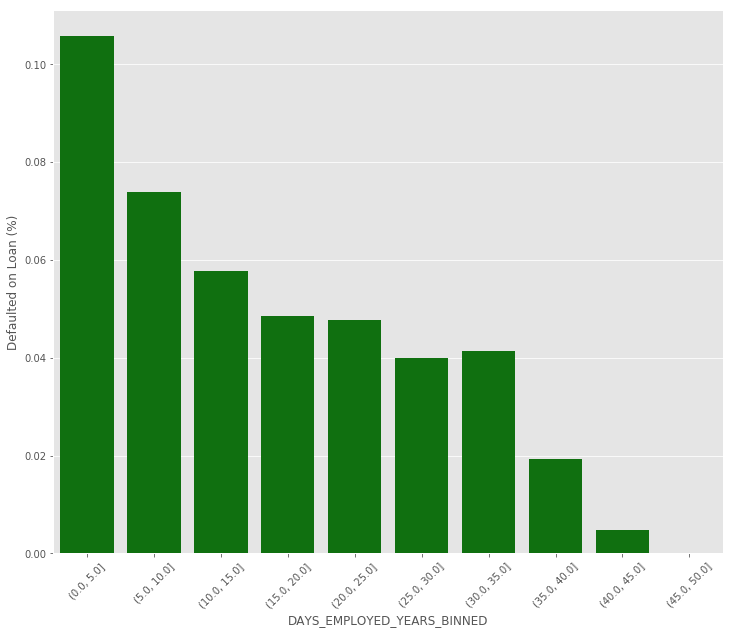

In [28]:
plot_days_bins('DAYS_EMPLOYED_YEARS_BINNED')

#### Applicants who only recently changed their registration are more likely to default on their loan payment:

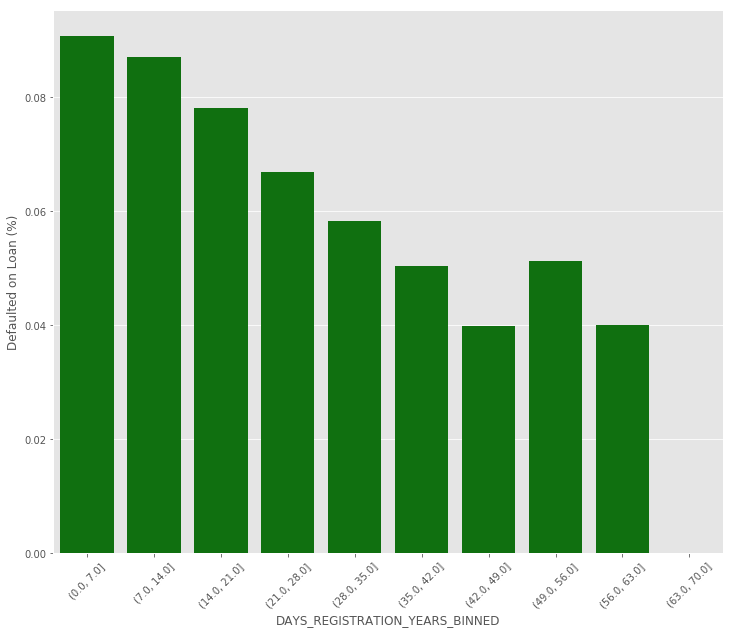

In [29]:
plot_days_bins('DAYS_REGISTRATION_YEARS_BINNED')

#### Applicants who changed their identification cards more recently are more likely to default on their loan payments:

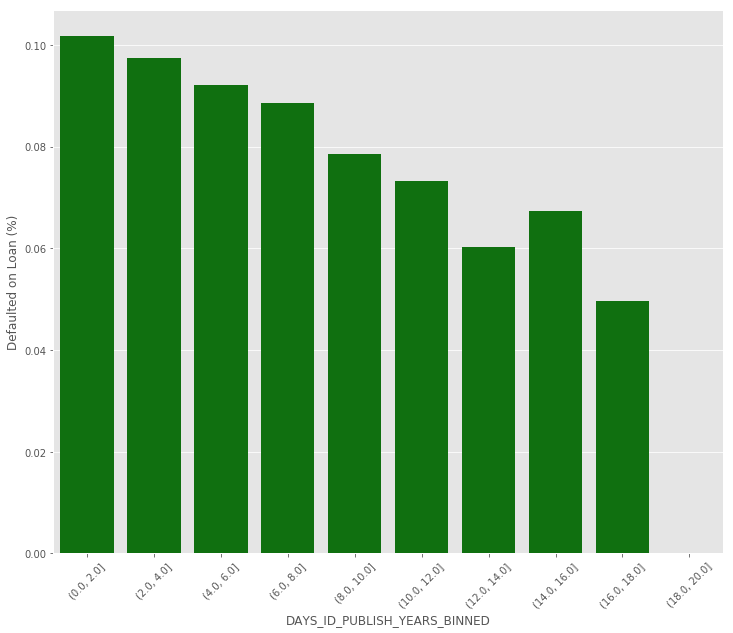

In [30]:
plot_days_bins('DAYS_ID_PUBLISH_YEARS_BINNED')

### __1c2 Feature Correlations - df_application__

Measure the strength of linear relationships betweeen target and respective features

#### Negative correlations imply that clients are less likely to default on their loans as that feature value increases.
- As clients increase with age, their default likelihood increases.

In [31]:
df_application.corr()['TARGET'].sort_values().head(15)

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_BIRTH                   -0.078239
DAYS_EMPLOYED                -0.074958
DAYS_ID_PUBLISH              -0.051457
DAYS_EMPLOYED_ANOMALY        -0.045987
FLOORSMAX_AVG                -0.044003
DAYS_REGISTRATION            -0.041975
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
FLOORSMIN_AVG                -0.033614
LIVINGAREA_AVG               -0.032997
TOTALAREA_MODE               -0.032596
Name: TARGET, dtype: float64

- More children = More likely to default
- A high region suggests that client is more likely to default on payment
- Older cars = More likely to default

In [32]:
df_application.corr()['TARGET'].sort_values().tail(15)

CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
OWN_CAR_AGE                    0.052246
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
TARGET                         1.000000
Name: TARGET, dtype: float64

#### What is EXT_SOURCE_1/2/3?

In [33]:
# To get a better sense of these unknown metrics, assess their correlation with other features and visualize with a heat map. 

df_ext_corrs_1 = (df_application.corr()
                                .abs()['EXT_SOURCE_1']
                                .sort_values(ascending = False)
                                .reset_index())
df_ext_corrs_2 = (df_application.corr()
                                .abs()['EXT_SOURCE_2']
                                .sort_values(ascending = False)
                                .reset_index())
df_ext_corrs_3 = (df_application.corr()
                                .abs()['EXT_SOURCE_3']
                                .sort_values(ascending = False)
                                .reset_index())

In [34]:
# Merge all three dataframes:

ext1_features = df_ext_corrs_1.sort_values(by=['EXT_SOURCE_1'],ascending = False).head(15)['index'].tolist()
ext2_features = df_ext_corrs_2.sort_values(by=['EXT_SOURCE_2'],ascending = False).head(15)['index'].tolist()
ext3_features = df_ext_corrs_3.sort_values(by=['EXT_SOURCE_3'],ascending = False).head(15)['index'].tolist()

In [35]:
# Combine all features important to the respective EXT_SOURCE feature and then visualize correlations:

# Combine list of the most correlated features for respective EXT_SOURCE feature
ext_features = [ext1_features + ext2_features + ext3_features]

# Remove duplicates  
ext_features = list(set(ext_features[0]))

# Reindex feature list to include EXT/TARGET in front for correlation matrix
ext_features = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','TARGET'] + ext_features 

In [36]:
df_ext_corrs = np.round(df_application[ext_features].corr().reindex(ext_features,axis = 1),decimals = 2)

#### EXT_SOURCE_1 seems to closely linked to the age of the applicant. The other features, however, don't provide much insight.

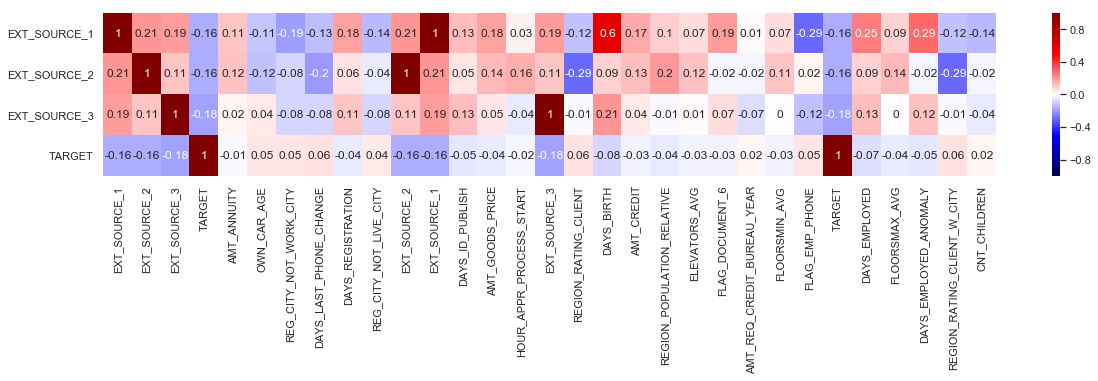

In [37]:
plt.figure(figsize = (20,3))

sns.set(font_scale = 1)
sns.heatmap(df_ext_corrs.iloc[0:4],cmap = 'seismic',vmin = -1,vmax = 1,annot = True);

### __1c3. EDA Summary__

#### Baseline
Coefficient and feature importance from baseline models suggest that "EXT_SOURCE" and "DAYS" features linearly related to target.

#### Null Values
Dropped extraneous housing features from applicant dataset.

#### Feature Anomalies
Replaced outliers with NaN and created separate boolean feature_ANOMALY column for following features:
- AMT_ANNUITY
- DAYS_EMPLOYED 
- CAR_AGE 
- CNT_FAM_MEMBERS 
- OBS_30_CNT_SOCIAL_CIRCLES
- OBS_60_CNT_SOCIAL_CIRCLES
- AMT_REQ_CREDIT_BUREAU_QRT

#### Feature Relationships
**Contract type**
- Data is heavily skewed towards cash loans
- Most defaults related to cash loans  

**Gender**  
- More women applicants than men.
- Women more likely to repay their loans

**Age**
- Younger applicants are more likely to default

**Family Status**
- No distinct target relationship
- Applicants with more children more likely to default

**Income / Occupation Type**
- Most applicants fall under the following categories:
    - commercial associate
    - state servant
    - pensioner
    - "working"
- "Working" applicants are more likely to default than other income types
- Applicants who stayed at their jobs for shorter periods are more likely to default

**Housing**
- Most applicants live in house / apartments

**Education**
- Most loans taken by individuals with a secondary education

**Misc Features**
- EXT SOURCE features are most linearly related to target.
- Applicants who recently changed their registration and identification cards are more likely to default. 
- Applicants with older cars more likely to default.


